# Writeup

## The 1D Kalman Filter

Here we implement the 1D Kalman filter and apply it to a simple problem involving global temperature data.

### Implementation

As in {cite}`young2011recursive` (Chapter 4.4, moving body example) we implement the linear Kalman filter to estimate a single state variable over time.

The code for that implementation is in {numref}`1d-kalman-implementation`.

### Demonstration on temperature data

As Young points out, there is a relationship between the filtering problem and regression. We can transform a regression problem into the filtering problem, then apply the Kalman Filter.

To demonstrate this, take the following dataset from NASA {cite}`nasa_temp`, which depicts the annual global average temperature as compared to a baseline temperature (the average temperature over the period of 1951 to 1980):

```{glue:figure} global_temp_data
:figwidth: 600px
:name: "global-temp-fig"
```

There is clearly an upward trend, but the data is noisy - from one year to the next the annual temperature average may go up or down. Furthermore, the upward trend appears nonlinear. How can we determine the trend from the noise?

We may transform this into filtering problem in a few ways:

1. Imagine the temperature is a noisy process and we have perfect measurements.
2. Imagine the temperature is fully deterministic process and we have noisy measurements.
3. Imagine the both the temperature process and our measurements have noise.

Then our kalman filter estimate will be a regression of this temperature data.

Let's go with option 3. If we design our process to assume a constant temperature ($x(k) = x(k-1) + \eta(k)$), then choose measurement noise variance $R$ = {glue:}`kalman_temp_R` and process noise $Q$ = {glue:}`kalman_temp_Q`, we get the following filter output:

```{glue:figure} global_temp_kalman
:name: "global_temp_kalman_1d"
:figwidth: 650px

The kalman-estimated temperature trend approximates the lowess regression of the noisy temperature data. Code in {numref}`1d-kalman-implementation`.
```

### A linear kalman filter applied to non-linear data?

Why was our linear-process-model Kalman Filter able to produce a non-linear regression? Even though we defined a constant temperature process, it is still a _stochastic_ process with some non-zero noise  $\vec{\eta}(k) \sim \mathcal{N}(0, Q)$. That uncertainty in the process-based predictions allows the measurements to pull the estimates upwards during the update steps.

The way we tune $Q$ and $R$ impacts this behavior. The two other extremes of parameter tuning (options 1 and 2 listed above) produce the following filter outputs:

```{glue:figure} kt_lqhr_fig
:name: "kt-lqhr-fig"
:figwidth: 500 px

Low Q, High R
```
```{glue:figure} kt_hqlr_fig
:name: "kt-hqlr-fig"
:figwidth: 500 px

High Q, Low R
```

{numref}`kt-lqhr-fig` Shows Low Q and High R ($Q$ = {glue:}`kt_lqhr_Q`, $R$ = {glue:}`kt_lqhr_R`). The result is an estimate that lags behind the upward trend of the measurements, because the constant-temp process model's predictions are weighted more heavily than the measurements.

{numref}`kt-hqlr-fig` Shows High Q and Low R ($Q$ = {glue:}`kt_hqlr_Q`, $R$ = {glue:}`kt_hqlr_R`). The result is a jagged estimate that hugs the datapoints tightly because our filter assumes no measurement noise.

### Behavior in the presence of data gaps

My implementation replicates Young's illustration of how the filter estimate's variance $P$ grows over a period of missing data.

```{glue:figure} kt_data_gap
:name: "kt-data-gap"
:figwidth: 500 px

The 3-$\sigma$ error bounds depicting $P(k)$ grows over a period of missing measurement data, before contracting quickly once new data points come in. Code in {numref}`kt_data_gap`.
```

## The Multivariate Kalman Filter

### Implementation and synthesis of input data

I implemented a multivariate Kalman Filter ({numref}`multivar_kf_implementation`) and synthesized a true 6-dimensional data series $\vec{x}(k)$ for a moving object under constant acceleration and its measurements $\vec{z}(k)$ {numref}`synth_true_state`.

```{glue:figure} mv_kf_pos
:name: "mv-kf-pos"
:figwidth: 500 px

The filter produces a position estimate that is convincingly close to the true state's postition.
```

If we pull out the position, velocity, and acceleration estimates and covariance matrices from $\vec{x}(k)$ and $P(k)$ we can visualize them separately ({numref}`multivar_kf_demo`):

```{glue:figure} mv_kf_pos_vel_acc
:name: "mv-kf-pos-vel-acc"
:figwidth: 750 px
```

```{glue:figure} mv_kf_pva_variances
:name: "mv-kf-pva-variances"
:figwidth: 750 px

Estimate variances over time
```

We see the position estimate quickly coverges close to the true position, and similarly the position estimate's variance 
$\begin{bmatrix}
\sigma_{x} & 0 \\
0 & \sigma_{y}
\end{bmatrix}$
rapidly reduces in magnitude. {numref}`mv-kf-pva-variances` shows the steep reduction in $\sigma_{x}$ and $\sigma_{y}$, and that a similar convergence plays out for the velocity estimates/variance at a slower rate, and for acceleration at a slower rate still.

### Accuracy Metrics

I explore __TODO__ 2 methods of quantifying accuracy:

1. Normalized Estimated Error Squared (NEES)
2. $3 \sigma$ Membership Accuracy Score: The ratio of estimates $\hat{x}(k)$ whose $3 \sigma$ covariance ellipses of $P(k)$ contain the true state $\vec{x}(k)$.

#### Normalized Estimated Error Squared (NEES)

TODO

#### $3 \sigma$ Membership Accuracy Score

I implemented this intuitive and simple way of quantifying the accuracy of the kalman filter's estimates.

The score works as follows. For each estimate $\hat{x}(k)$, check if the associated true state point $\vec{x}(k)$ falls within the $3\sigma$ covariance ellipse for $P(k)$. Then simply compute the ratio of estimates for which $\vec{x}(k)$ is a member of $\hat{x}(k)$'s ellipse out of all estimates. Implementation in {numref}`3sig_membership_implementation`.

Here's a visualized example, where the kalman filter's $3\sigma$ membership accuracy score is {glue:}`3sm_ratio`:
```{glue:figure} 3sig_membership_viz
:name: "3sig-membership-viz"
:figwidth: 650 px

Each ($\hat{x}(k)$, $\vec{x}(k)$) pair is connected by a line segment, which is colored green if $\vec{x}(k)$ is a member of $\hat{x}(k)$'s $3\sigma$ ellipse and red otherwise.
```

_Note: This score only useful for relative comparisions between filter runs on the same dataset, which is primarily what I'm doing here. Furthermore, the scalar nature of the score loses information about the filter performance, such as the relative speed at which the residual magnitudes $|\vec{x}(k)-\hat{x}(k)|$ coverge._

### Performance

Our filter's behavior is dependent on our choice of a few parameters, including an intial state estimate $\hat{x}(0)$, initial estimate covariance $P(0)$, and covariances $R$, and $Q$. How sensitive is the filter's accuracy to the perturbations to those parameters?

#### Initial state estimate perturbation

__TODO__ Describe and cite the method for perturbing the intial state estimate.
__TODO__ Include both the 3sig-membership score and NEES score answers to this question.

```{glue:figure} 3sm_v_perturbation
:name: "3sm-v-perturbation"
:figwidth: 750 px
```

#### $Q$,$R$ perturbation from true values.

In the real world, we may not know the true values of $Q$ and $R$. How does the filter's accuracy change as a function of a perturbations of $Q$ and $R$ from their true values?

# Code

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from importlib import reload
from scipy.stats import chi2
from myst_nb import glue
import utils
reload(utils)

rng = np.random.default_rng(seed=1)
from IPython.core.debugger import set_trace

## Global Temp Anomaly Data

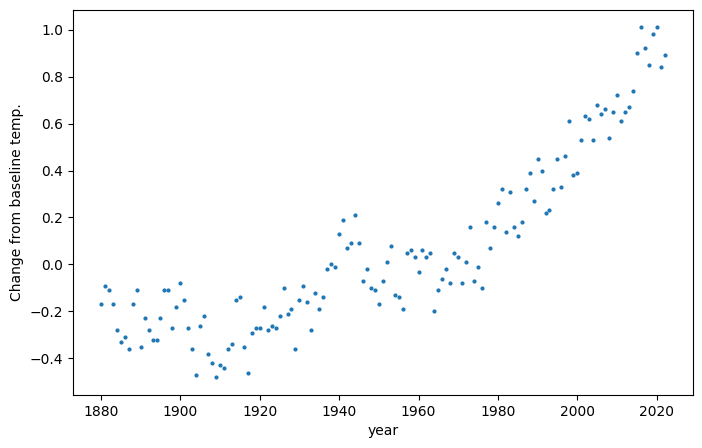

In [2]:
df = pd.read_csv('temp_anomalies.csv')
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(df.year, df.no_smoothing, marker='o', linestyle='none', markersize=2)
plt.xlabel('year')
plt.ylabel('Change from baseline temp.')
#plt.show()
glue("global_temp_data", fig, display=False)

## The 1D Kalman Filter

(1d-kalman-implementation)=
### Implementation

0.5

0.05

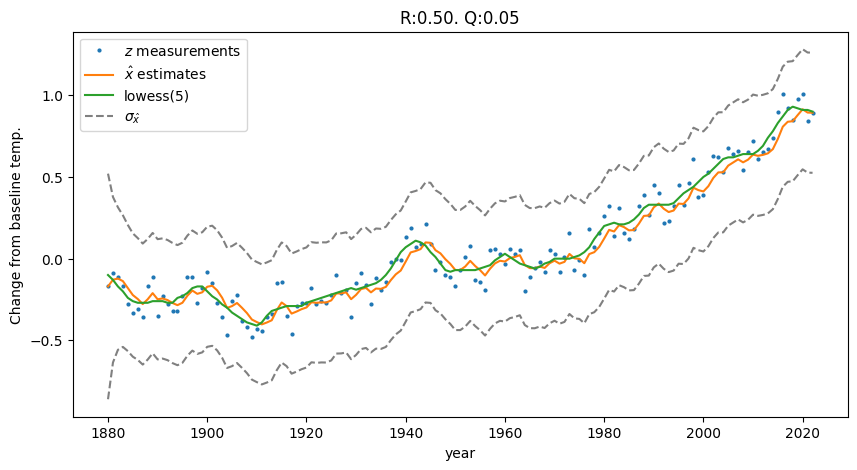

In [3]:
# Run the kalman filter algorithm on a series of observations and return
# the estimated state series
def kalman_1d(zs, R, Q, P_0, x_0):
    """
    Args:
        zs: Measurement series. An Nx1 array.
        R: Measurement noise variance.
        Q: Process noise variance
        P: Prior (prediction) variance.
    """
    # Initialize system and filter state
    xs = np.full(len(zs), np.nan)
    Ps = np.full(len(zs), np.nan)
    
    # Prior
    P = P_0
    x = x_0

    # TODO: Should we exclude prediction calculation for first iteration?
    for i in range(len(zs)):
        # PREDICT STEP - Process model update
        # dx = Gauss(0, Q)
        x = x + 0 # Prediction mean
        P = P + Q # Prediction var

        # UPDATE STEP (if there is a measurement at this timestep)
        if not np.isnan(zs[i]):
            resid = zs[i] - x

            # Kalman Gain
            K = P / (P + R)

            # Posterior: Use kalman gain to scale the residual between prediction and measurement
            x = x + K * resid
            P = (1 - K) * P

        # Save results
        xs[i] = x
        Ps[i] = P
        
    return xs, Ps

# Configure and run the filter
R = 0.5 # Measurement variance
Q = 0.05 # Process noise variance
glue('kalman_temp_R', R)
glue('kalman_temp_Q', Q)
zs = df.no_smoothing # Measurements
P_0 = 10
x_0 = zs[0]
xs, Ps = kalman_1d(zs, R, Q, P_0, x_0)

# Plot
fig, ax = plt.subplots(1, figsize=(10,5))
plt.plot(df.year, zs, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
plt.plot(df.year, xs, label=r'$\hat{x}$ estimates')
plt.plot(df.year, df.lowess_5, label=r'lowess(5)')
plt.plot(df.year, xs + np.sqrt(Ps), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
plt.plot(df.year, xs - np.sqrt(Ps), linestyle='dashed', color='gray')
plt.title(f'R:{R:.02f}. Q:{Q:.02f}')
plt.xlabel('year')
plt.ylabel('Change from baseline temp.')
plt.legend()
plt.show()
glue("global_temp_kalman", fig, display=False)

(kt_data_gap)=
### Exploring how the kalman filter behaves with data gaps

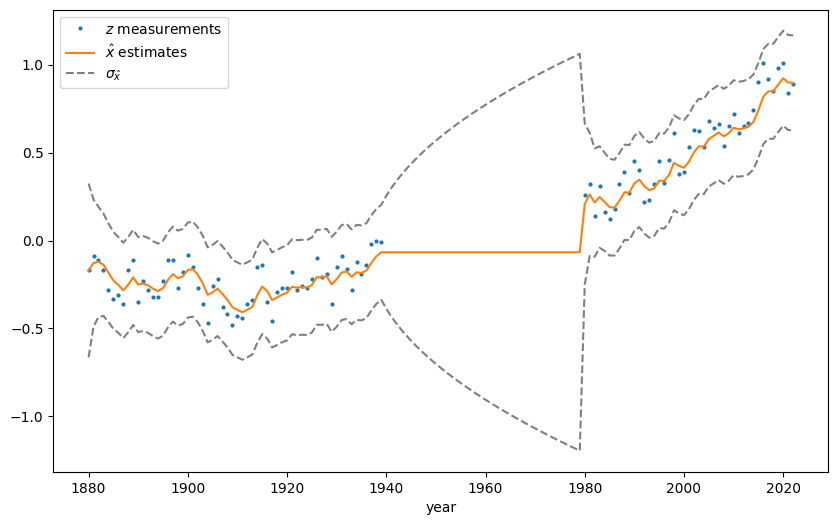

In [4]:
R = 0.25 # Measurement variance
Q = 0.03 # Process noise variance
zs = df.no_smoothing.to_numpy() # Measurements

# Define an data gap interval
start = 60 # Years beyond 1880
end = 100
gap_zs = np.copy(zs)
gap_zs[start:end] = np.nan
t = df.year.to_numpy()

fig, ax = plt.subplots(1, figsize=(10,6))
xs, Ps = kalman_1d(gap_zs, R, Q, P_0, x_0)
plt.plot(t, gap_zs, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
plt.plot(t, xs, label=r'$\hat{x}$ estimates')
plt.plot(t, xs + np.sqrt(Ps), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
plt.plot(t, xs - np.sqrt(Ps), linestyle='dashed', color='gray')
plt.xlabel('year')
plt.legend()
plt.show()
glue("kt_data_gap", fig, display=False)

__TODO__ The above gaps might look better if the process model assumed a constant velocity of the last velocity seen?

### Exploring the parameter space of $Q$ x $R$

Illustrating how the measurement noise covariance $R$, and process noise covariance is $Q$ affect the behavior of the 1D Kalman filter.

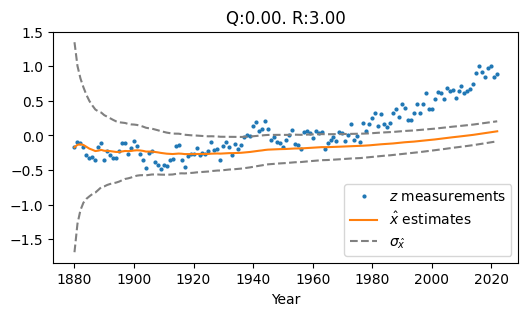

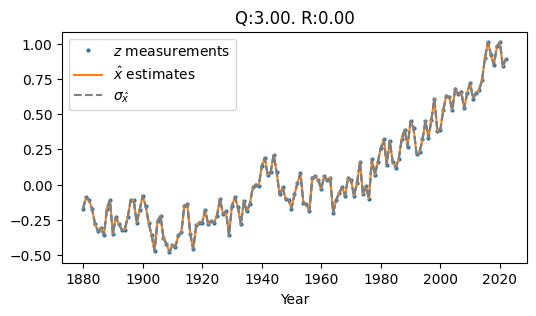

In [5]:
def plot_temp_kalman_for_QR(Q, R, ax):
    P_0 = 10
    x_0 = zs[0]
    xs, Ps = kalman_1d(zs, R, Q, P_0, x_0)
    ax.plot(df.year, zs, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
    ax.plot(df.year, xs, label=r'$\hat{x}$ estimates')
    ax.plot(df.year, xs + np.sqrt(Ps), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
    ax.plot(df.year, xs - np.sqrt(Ps), linestyle='dashed', color='gray')
    ax.set_title(f'Q:{Q:.02f}. R:{R:.02f}')
    ax.set_xlabel('Year')
    ax.legend()

# Low Q, High R
Q, R = 0.0, 3.0
glue('kt_lqhr_Q', Q, display=False)
glue('kt_lqhr_R', R, display=False)
fig, ax = plt.subplots(figsize=(6,3))
plot_temp_kalman_for_QR(Q, R, ax)
glue("kt_lqhr_fig", fig, display=False)

# High Q, Low R
Q, R = 3.0, 0.0
glue('kt_hqlr_Q', Q, display=False)
glue('kt_hqlr_R', R, display=False)
fig, ax = plt.subplots(figsize=(6,3))
plot_temp_kalman_for_QR(Q, R, ax)
glue("kt_hqlr_fig", fig, display=False)

## The Bayesian Intuition underlying the Kalman Filter

In his excellent exploration of the Kalman Filter {cite}`labbe`, Roger Labbe illustrates the bayesian intuition underlying the kalman filter algorithm. I have implemented the bayesian approach {numref}`bayesian-1d-kalman`, and show it has the same result as the traditional implementation.

- __TODO__ explaining the Bayesian connection is a nice to have, save it for after the core presentation of your implementations is done.
- __TODO__ If including this section, credit Labbe more explicitly for your implementation.

## Multidimensional Kalman Filter (for a Process With Constant Acceleration)

In this section I synthesize data for a object moving in 2 dimensions under a constant acceleration (due to gravity), then apply a multidimensional kalman filter and analyze the filter's output and accuracy.

(synth_true_state)=
### Synthesizing true state $\vec{x}(k)$

We will track the following 6-dimensional state vector: $\vec{x} = \begin{bmatrix} x & \dot{x} & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^T$

Let's start by defining a _deterministic_ process model (simple newtonian motion under constant acceleration) for state $\vec{x}(k)$ as:

$$
\vec{x}(k) =
\begin{bmatrix}
x(k) \\
\dot{x}(k) \\
\ddot{x}(k) \\
y(k) \\
\dot{y}(k) \\
\ddot{y}(k) \\
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t & \frac{1}{2}(\Delta t)^2 & 0 & 0 & 0 \\
0 & 1 & \Delta t & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t & \frac{1}{2}(\Delta t)^2  \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x(k-1) \\
\dot{x}(k-1) \\
\ddot{x}(k-1) \\
y(k-1) \\
\dot{y}(k-1) \\
\ddot{y}(k-1) \\
\end{bmatrix}
=
F \vec{x}(k-1)
$$

Where $F$ is our transition matrix, $\vec{x}(k-1)$ is the state at the previous timestep, and $\Delta t$ is the length of the timestep.

Note that this implies constant acceleration in both dimensions. We'll set our initial acceleration vector as acceleration due to gravity: $\begin{bmatrix} \ddot{x} &  \ddot{y} \end{bmatrix}^T = \begin{bmatrix} 0 &  -9.81 \end{bmatrix}^T $

Now let's simulate the trajectory of our deterministic process $\vec{x}(k)$ over a period of time:

In [6]:
# Simulation config

# Timestep
dt = 0.1

# Number of seconds of simulation
T = 5
N = T / dt
assert N.is_integer()
N = int(N)

print(f'Simulating {T:.02f} seconds. {N} timesteps')

Simulating 5.00 seconds. 50 timesteps


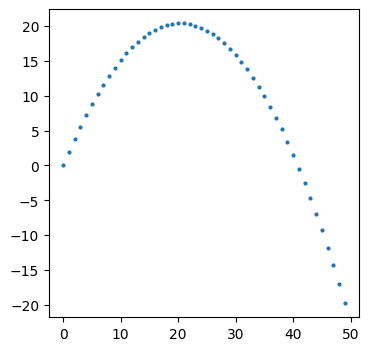

In [7]:
# Initial position
x_0, y_0 = [0., 0]

# Initial velocity
vx_0, vy_0 = [10., 20]

# Initial (constant) acceleration
ax_0, ay_0 = [0, -9.81]

# Initial state
n = 6 # State dimensionality
x0 = np.array([x_0, vx_0, ax_0, y_0, vy_0, ay_0])

# Transition matrix
F = np.array([
    [1., dt, 0.5*dt**2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, 0.5*dt**2],
    [0, 0, 0, 0, 1, dt], 
    [0, 0, 0, 0, 0, 1],
])

# Results matrix. Each row is the state for one timestep
xs = np.full((N, n), np.nan)
xs[0,:] = x0

for k in range(1, N):
    xs[k, :] = F @ xs[k-1, :]
    
plt.rcParams["figure.figsize"] = (4,4)
plt.plot(xs[:,0], xs[:,3], marker='o', linestyle='none', markersize=2)
plt.show()

This gives us a good foundation for our object's motion. But we're ultimately interested in a _stochastic_ process: $\vec{x}(k) = F \vec{x}(k-1) + \vec{\eta}(k-1)$

So let's add __noise__ $\vec{\eta}(k) \sim \mathcal{N}(0,Q)$ to the process. We simplify/approximate a process noise covariance matrix that confines the variance to the acceleration components of the process:

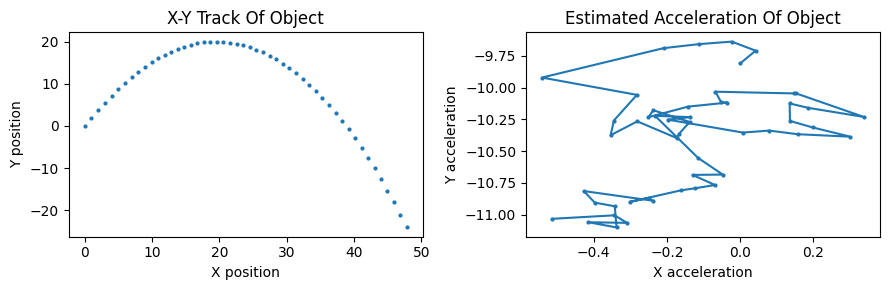

In [8]:
# Approximate Q as only variance for the acceleration components ax and ay.
accel_var = 0.015
Q_true = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, accel_var, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, accel_var],
])

# Results matrix. Each row is the state for one timestep
true_xs = np.full((N, 6), np.nan)
true_xs[0,:] = x0

for k in range(1, N):
    # Process noise - only affects acceleration
    eta = rng.multivariate_normal(np.zeros(n), Q_true)
    
    true_xs[k, :] = F @ true_xs[k-1, :] + eta

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
ax[0].plot(true_xs[:,0], true_xs[:,3], marker='o', linestyle='none', markersize=2)
ax[0].set_title('X-Y Track Of Object')
ax[0].set_xlabel('X position')
ax[0].set_ylabel('Y position')
ax[1].plot(true_xs[:,2], true_xs[:,5], marker='o', markersize=2)
ax[1].set_title('Estimated Acceleration Of Object')
ax[1].set_xlabel('X acceleration')
ax[1].set_ylabel('Y acceleration')
fig.tight_layout()
plt.show()

### Synthesizing measurements

To synthesize our measurement series $\vec{z}(k)$, we add bivariate white noise $\vec{\xi}(k) \sim \mathcal{N}(0,R)$ to our synthesized true state series $\vec{x}(k)$.

We will assume we only have positional sensors to take measurements, i.e. $\vec{z}(k) = [z_x(k), z_y(k)]^T$. As there are no velocity or acceleration components to our measurements, $\dot{x}$, $\ddot{x}$, $\dot{y}$, and $\ddot{y}$ are all _hidden variables_ ({cite}`labbe` Chpt. 5).

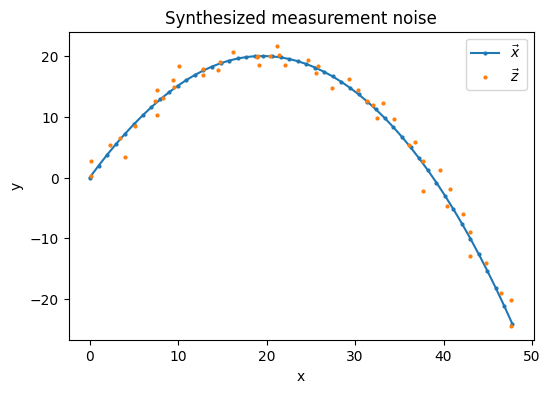

In [9]:
# Synthesize measurements by adding random noise to the true position series
z_var = 1.2
# Measurement (position) noise covariance matrix (independent bivariate normal)
R_true = np.array([
    [z_var, 0],
    [0, z_var],
])
zs = np.full((N, 2), np.nan)
zs[:, 0] = true_xs[:, 0] # x positions
zs[:, 1] = true_xs[:, 3] # y positions

zs = zs + rng.multivariate_normal(np.zeros(2), R_true, N)

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
plt.title('Synthesized measurement noise')
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.show()

(multivar_kf_implementation)=
### Multidimensional Filter Implementation

Now that we have our synthetic observations $\vec{z}(k)$ we can apply a multivariate Kalman filter to obtain estimates $\hat{x}(k)$ and do some analysis.

First we must implement that filter. The implementation below draws heavily from {cite}`labbe` Chpt. 6, extending that implementation to track 6 state variables instead of 2.

In [10]:
# Matrix H converts state vectors into measurement space
# In this model, that means grabbing the position values
H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
])

def kalman_6d(zs, R, Q, x_0, P_0):
    assert len(zs) == N
    # Store filter estimates (means and variances)
    xs = np.full((N, 6), np.nan)
    Ps = np.full((N, 6, 6), np.nan)
    
    # Initial estimate
    xs[0,:] = x_0
    Ps[0] = P_0
    
    x = np.copy(x_0)
    P = np.copy(P_0)

    # TODO: Should we exclude prediction calculation for first iteration?
    # But we still want to do the correction for the first iteration, right?
    for k in range(1, N):
        # 1) PREDICT
        prior = F @ xs[k-1,:]
        P = F @ P @ F.T + Q

        # 2) UPDATE
        # TODO: Currently using Labbe notation. Switch to Young?

        # Calculate system uncertainty
        S = H @ P @ H.T + R

        # Calculate kalman gain
        K = P @ H.T @ np.linalg.inv(S)

        # Calculate residual: Difference between prediction and measurement
        # (In measurement space)
        y = zs[k] - H @ prior

        # Caculate posterior state (corrected estimate and covar)
        post = prior + K @ y
        P = P - K @ H @ P

        # Save
        xs[k] = post
        Ps[k] = P
        
    return xs, Ps

# TODO: Known bug. When R and Q are zero matrices, the value of S's elements get tiny (floating
# point errors representing zero), which leads inv(S) to produce a matrix of nans. This produces
# nan estimates from that iteration onwards. Not sure how to avoid, but a workaround is to not pass
# in Q and R made of all zeros.

(multivar_kf_demo)=
### Demonstration on synthetic data

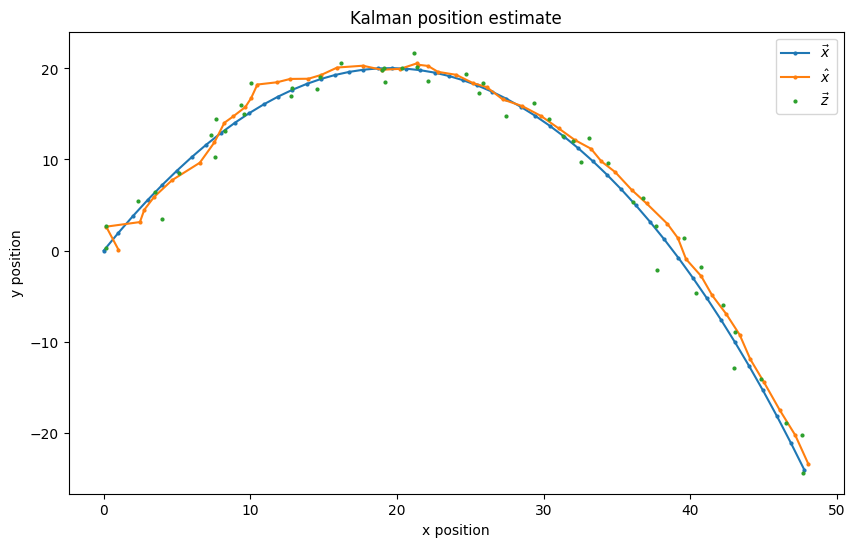

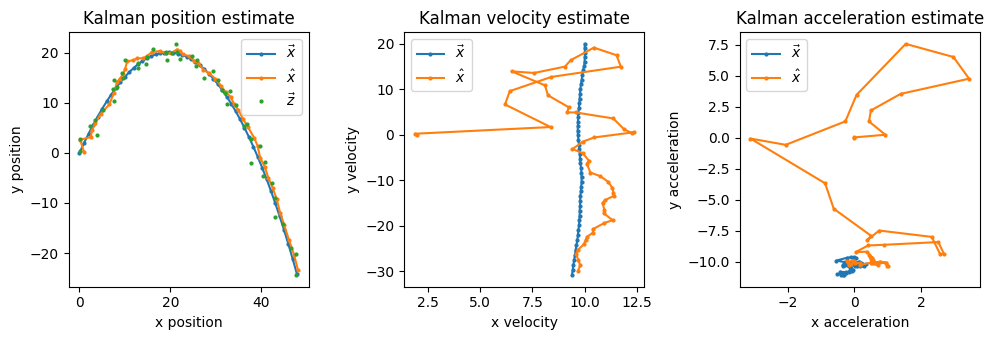

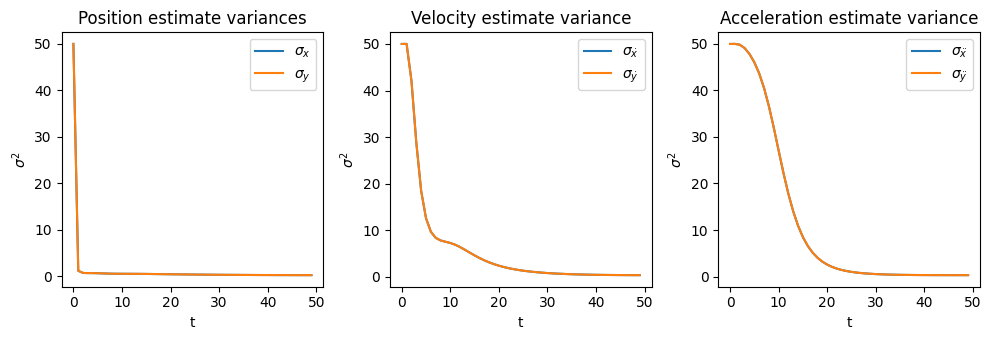

In [34]:
# Initialize filter state
# Guess the position somewhat accurately, leave the velocity and acceleration state guesses as 0
x_0 = np.array([1, 2, 0, 0.1, 0, 0])
P_0 = np.eye(6) * 50 # Start with very low confidence in predictions

# Assume we can configure the system's process and measurement noise params correctly
Q = Q_true
R = R_true

xs, Ps = kalman_6d(zs, R, Q, x_0, P_0)
    
# Extract covariances for position, velocity, and acceleration
pos_vars, vel_vars, acc_vars = utils.separate_covar_series(Ps)
    
# Plot track, measurements, and estimate for position
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
ax.plot(xs[:,0], xs[:,3], label=r'$\hat{x}$',  marker='o', markersize=2)
ax.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
ax.set_title('Kalman position estimate')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.legend()
plt.show()
glue('mv_kf_pos', fig, display=False)

# Plot track, measurements, and estimate for pos, vel, acc in a tight figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3.5))
ax[0].plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
ax[0].plot(xs[:,0], xs[:,3], label=r'$\hat{x}$',  marker='o', markersize=2)
ax[0].plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
ax[0].set_title('Kalman position estimate')
ax[0].set_xlabel('x position')
ax[0].set_ylabel('y position')
ax[0].legend()
ax[1].plot(true_xs[:,1], true_xs[:,4], label=r'$\vec{x}$',  marker='o', markersize=2)
ax[1].plot(xs[:,1], xs[:,4], label=r'$\hat{x}$',  marker='o', markersize=2)
ax[1].set_title('Kalman velocity estimate')
ax[1].set_xlabel('x velocity')
ax[1].set_ylabel('y velocity')
ax[1].legend()
ax[2].plot(true_xs[:,2], true_xs[:,5], label=r'$\vec{x}$',  marker='o', markersize=2)
ax[2].plot(xs[:,2], xs[:,5], label=r'$\hat{x}$',  marker='o', markersize=2)
ax[2].set_title('Kalman acceleration estimate')
ax[2].set_xlabel('x acceleration')
ax[2].set_ylabel('y acceleration')
ax[2].legend()
fig.tight_layout()
plt.show()
glue('mv_kf_pos_vel_acc', fig, display=False)

# Plot positional variance
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3.5))
ax[0].plot(np.arange(0,N), pos_vars[:,0,0], label=r'$\sigma_x$')
ax[0].plot(np.arange(0,N), pos_vars[:,1,1], label=r'$\sigma_y$')
ax[0].set_title('Position estimate variances')
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\sigma^2$')
ax[0].legend()
ax[1].plot(np.arange(0,N), vel_vars[:,0,0], label=r'$\sigma_{\dot{x}}$')
ax[1].plot(np.arange(0,N), vel_vars[:,1,1], label=r'$\sigma_{\dot{y}}$')
ax[1].set_title('Velocity estimate variance')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\sigma^2$')
ax[1].legend()
ax[2].plot(np.arange(0,N), acc_vars[:,0,0], label=r'$\sigma_{\ddot{x}}$')
ax[2].plot(np.arange(0,N), acc_vars[:,1,1], label=r'$\sigma_{\ddot{y}}$')
ax[2].set_title('Acceleration estimate variance')
ax[2].set_xlabel('t')
ax[2].set_ylabel(r'$\sigma^2$')
ax[2].legend()
fig.tight_layout()
plt.show()
glue('mv_kf_pva_variances', fig, display=False)

# TODO could plot x and y pos, vel, and acc as functions of t.
# TODO Plot x(t) and vel_x(t) slopes overlaid

The covariance matrix $P$ (for a given k):

$
P = \begin{bmatrix}
\sigma_{x}^2 & \sigma_{x,\dot{x}}^2 & \sigma_{x,\ddot{x}}^2 & \sigma_{x,y}^2 & \sigma_{x,\dot{y}}^2 & \sigma_{x,\ddot{y}}^2  \\
\sigma_{\dot{x},x}^2 & \sigma_{\dot{x}}^2 & \sigma_{\dot{x},\ddot{x}}^2 & \sigma_{\dot{x},y}^2 & \sigma_{\dot{x},\dot{y}}^2 & \sigma_{\dot{x},\ddot{y}}^2  \\
\sigma_{\ddot{x},x}^2 & \sigma_{\ddot{x},\dot{x}}^2 & \sigma_{\ddot{x}}^2 & \sigma_{\ddot{x},y}^2 & \sigma_{\ddot{x},\dot{y}}^2 & \sigma_{\ddot{x},\ddot{y}}^2  \\
\sigma_{y,x}^2 & \sigma_{y,\dot{x}}^2 & \sigma_{y,\ddot{x}}^2 & \sigma_{y}^2 & \sigma_{y,\dot{y}}^2 & \sigma_{y,\ddot{y}}^2  \\
\sigma_{\dot{y},x}^2 & \sigma_{\dot{y},\dot{x}}^2 & \sigma_{\dot{y},\ddot{x}}^2 & \sigma_{\dot{y},y}^2 & \sigma_{\dot{y}}^2 & \sigma_{\dot{y},\ddot{y}}^2  \\
\sigma_{\ddot{y},x}^2 & \sigma_{\ddot{y},\dot{x}}^2 & \sigma_{\ddot{y},\ddot{x}}^2 & \sigma_{\ddot{y},y}^2 & \sigma_{\ddot{y},\dot{y}}^2 & \sigma_{\ddot{y}}^2 
\end{bmatrix}
$

### Exploring covariance of position with velocity

TODO: Graph $\sigma_{x,\dot{x}}^2$ and $\sigma_{y,\dot{y}}^2$ for first few timesteps.

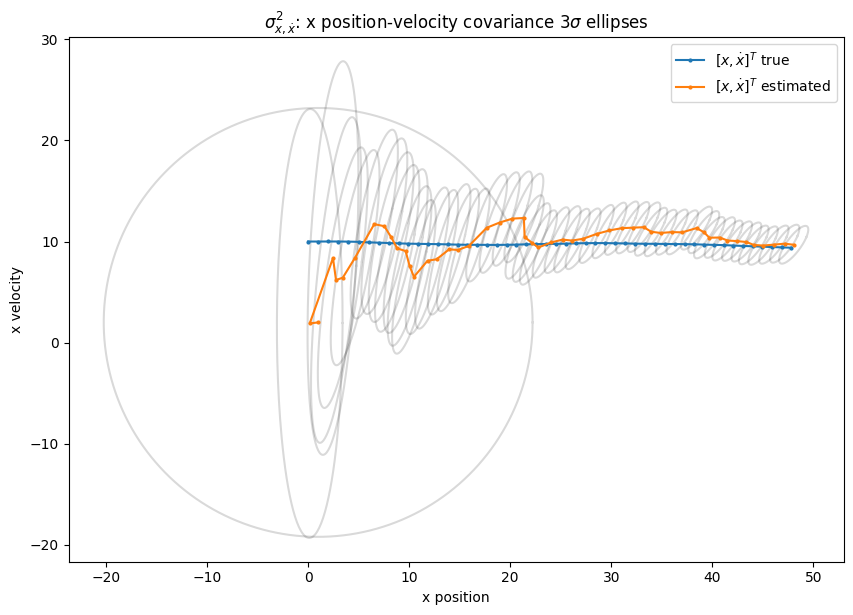

In [35]:
# Extract pos-vel covariance in the x dimension
pos_vel_x_vars = np.full((N, 2, 2), np.nan)
for i in range(len(Ps)):
    P = Ps[i]
    pos_vel_x_vars[i] = np.array([[P[0,0], P[0,1]],[P[1,0], P[1,1]]])

# Plot
figure, axes = plt.subplots(1, figsize=(10,10)) 
axes.set_aspect(1) 
# Plot prediction 3-sigma covariance elipses
for i in range(len(pos_vel_x_vars)):
    S = pos_vel_x_vars[i]
    mu = np.array([xs[i,0], xs[i,1]])
    utils.plot_covar_ellipse(S, mu, alpha=0.15)
plt.plot(true_xs[:,0], true_xs[:,1], label=r'$[x,\dot{x}]^T$ true',  marker='o', markersize=2)
plt.plot(xs[:,0], xs[:,1], label=r'$[x,\dot{x}]^T$ estimated',  marker='o', markersize=2)
#plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
plt.title(r'$\sigma_{x,\dot{x}}^2$: x position-velocity covariance $3\sigma$ ellipses')
plt.xlabel('x position')
plt.ylabel('x velocity')
plt.legend()
plt.show()

Notes: Above displays how the filter learns the covariance between position and the hidden variable velocity over time. It starts with prediction uncertainty as a wide variance fully uncorrelated (circular) ellipse, then converges over time to the way it looks in the end: with a positive covariance between position and velocity.

__TODO__ We could expand this to show $\sigma_{y,\dot{y}}^2$, $\sigma_{\dot{x},\ddot{x}}^2$, etc. Doubt if it will illustrate much more beyond the above diagram though.

### Quantifying the Accuracy of the Kalman Filter's Predictions

Methods of quantifying:

__TODO__ explore:
- Develop an intuitive custom score: __Confirm what percent of true values are within the 3-sigma ellipses of the estimates.__

#### NEES

Sources
- [kalman-filter.com](https://kalman-filter.com/normalized-estimation-error-squared/)
- [Labbe](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb)

Error vectors: $\tilde{x}(k) = \vec{x}(k) - \hat{x}(k)$

NEES (scalar values): $\epsilon(k) = \tilde{x}(k)^T \textbf{P}^{-1} \tilde{x}(k)$

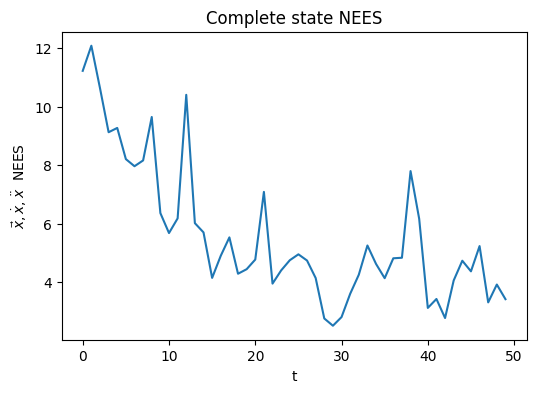

Complete NEES score: 5.615083226038849


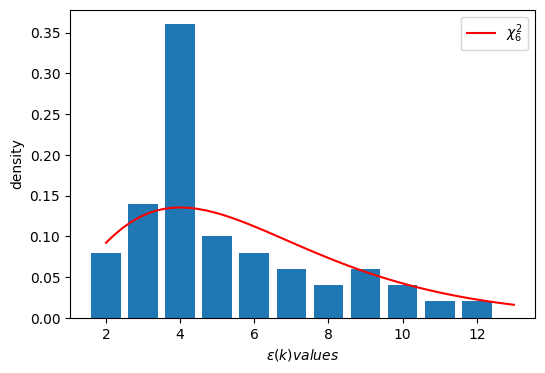

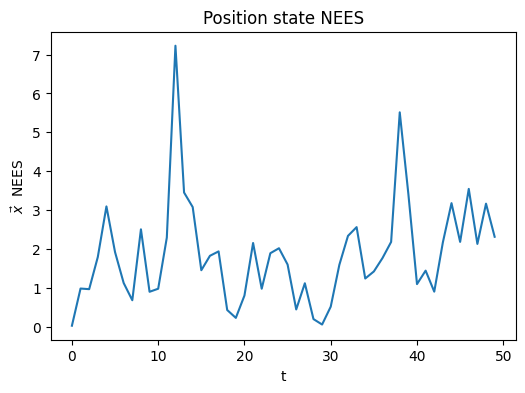

Position NEES score: 1.8521419590449708


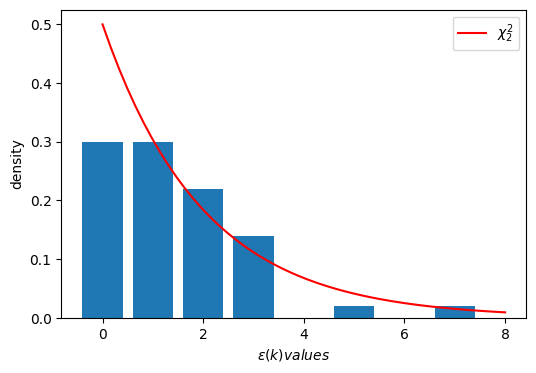

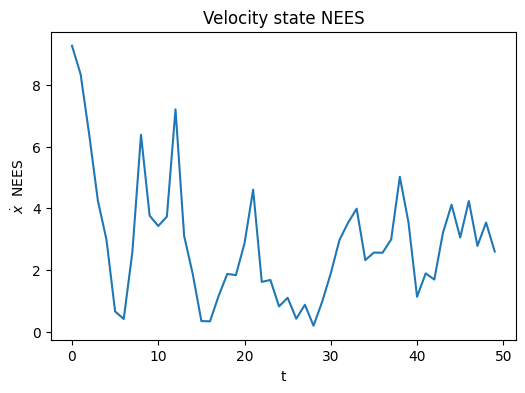

Velocity NEES score: 2.893379246281296


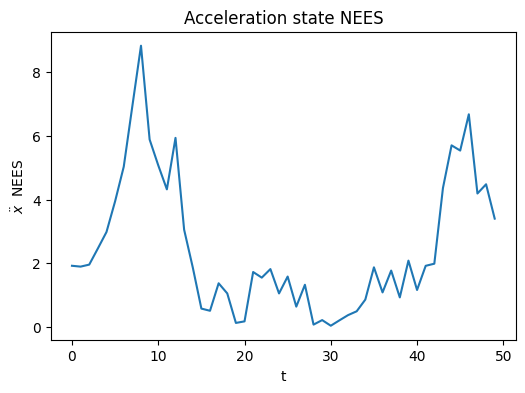

Acceleration NEES score: 2.503600489582321


In [37]:
xs_pos, xs_vel, xs_acc = utils.separate_state_series(xs)
true_xs_pos, true_xs_vel, true_xs_acc = utils.separate_state_series(true_xs)
Ps_pos, Ps_vel, Ps_acc = utils.separate_covar_series(Ps)

# Calculate the NEES series
def nees_series(true_xs, xs, Ps):
    x_tilde = true_xs - xs
    nees_ts = np.full(N, np.nan)
    for k in range(N): # TODO can we vectorize this loop?
        nees_ts[k] = x_tilde[k].T @ np.linalg.inv(Ps[k]) @ x_tilde[k]
    return nees_ts
        
# Calculate the mean NEES score
def mean_nees(true_xs, xs, Ps):
    nees_ts = nees_series(true_xs, xs, Ps)
    return np.mean(nees_ts)

## COMPLETE state vector NEES 
nees_ts = nees_series(true_xs, xs, Ps)
plt.plot(np.arange(0,N), nees_ts)
plt.title('Complete state NEES')
plt.xlabel('t')
plt.ylabel(r'$\vec{x},\dot{x},\ddot{x}$  NEES')
plt.show() 

# A 'good' NEES score is: the average value of the NEES timeseries is less than the dimension of the state vector
print(f'Complete NEES score: {mean_nees(true_xs, xs, Ps)}')

# Complete state NEES distribution compared to chi-2
domain = (np.floor(np.min(nees_ts)), np.ceil(np.max(nees_ts)))
# Set the number of histogram bins so each has width unity
num_bins = int(domain[1] - domain[0])
h_vals, bins = np.histogram(nees_ts, bins=num_bins, range=domain, density=True)
plt.bar(bins[:-1], h_vals)
domain_ls = np.linspace(domain[0],domain[1])
plt.plot(domain_ls, chi2.pdf(domain_ls, df=6), color='r', label=r'$\chi^2_6$')
plt.legend()
plt.xlabel(r'$\epsilon(k) values$')
plt.ylabel(r'density')
plt.show()

# POSITION NEES
# The difference between the estimate and the true position state
nees_ts = nees_series(true_xs_pos, xs_pos, Ps_pos)
plt.plot(np.arange(0,N), nees_ts)
plt.title('Position state NEES')
plt.xlabel('t')
plt.ylabel(r'$\vec{x}$  NEES')
plt.show()
print(f'Position NEES score: {mean_nees(true_xs_pos, xs_pos, Ps_pos)}')

# Position NEES distribution compared to chi-2
domain = (np.floor(np.min(nees_ts)), np.ceil(np.max(nees_ts)))
# Set the number of histogram bins so each has width unity
num_bins = int(domain[1] - domain[0])
h_vals, bins = np.histogram(nees_ts, bins=num_bins, range=domain, density=True)
plt.bar(bins[:-1], h_vals)
domain_ls = np.linspace(domain[0],domain[1])
plt.plot(domain_ls, chi2.pdf(domain_ls, df=2), color='r', label=r'$\chi^2_2$')
plt.legend()
plt.xlabel(r'$\epsilon(k) values$')
plt.ylabel(r'density')
plt.show()

# VELOCITY NEES
nees_ts = nees_series(true_xs_vel, xs_vel, Ps_vel)
plt.plot(np.arange(0,N), nees_ts)
plt.title('Velocity state NEES')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$  NEES')
plt.show()
print(f'Velocity NEES score: {mean_nees(true_xs_vel, xs_vel, Ps_vel)}')

# ACCELERATION NEES
nees_ts = nees_series(true_xs_acc, xs_acc, Ps_acc)
plt.plot(np.arange(0,N), nees_ts)
plt.title('Acceleration state NEES')
plt.xlabel('t')
plt.ylabel(r'$\ddot{x}$  NEES')
plt.show()
print(f'Acceleration NEES score: {mean_nees(true_xs_acc, xs_acc, Ps_acc)}')

Above we have shown:
- The full state vector $\vec{x}$ (as well as the split out position, velocity, and accelerate state 2-tuples) comply with the $\chi^2_k$ distributions, and that the average value of the NEES series is less than the number of elements in the respective state vector.
- The state vectors $\epsilon(k)$ distributions are indeed $\chi^2_k$, verified by overlaying the actual NEES values histogram with the $\chi^2_k$ pdfs.

__QUESTIONS__:

- I've shown the the NEES values are $\chi^2_k$-distributed, and therefor have the expected values of $k$. How does this related to Labbes informal assertion that as long as average NEES value is $\lt k$ the filter is performing well? Why would it be anything other than equal to k?
  - TODO: Read the paper recommended by labbe.

(3sig_membership_implementation)=
#### $3\sigma$ Membership Accuracy Score: Do the true positions $\vec{x}(k)$ fall within the $\hat{x}(k)$ estimates' $3\sigma$ confidence ellipses?

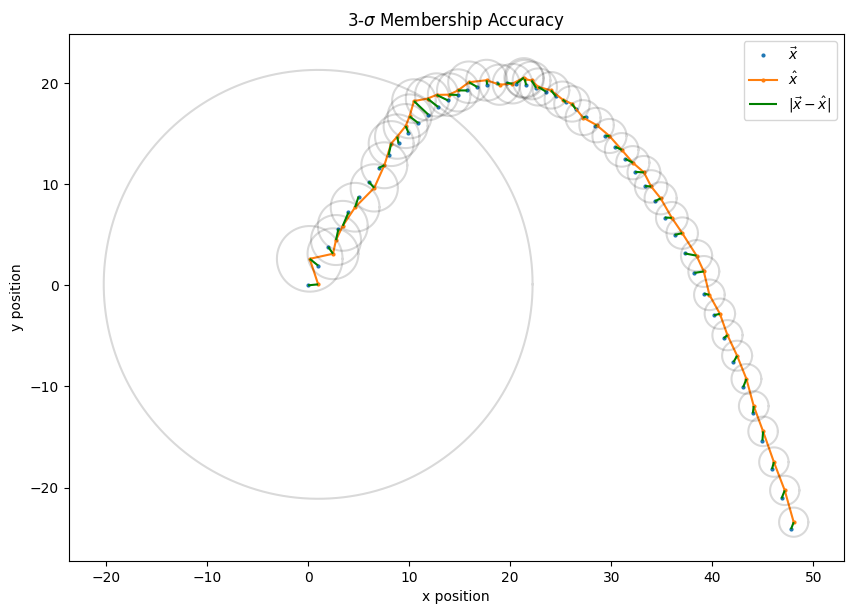

Percent of estimate covar ellipse containing true state: 100.00%
R:
[[1.2 0. ]
 [0.  1.2]]
Q:
[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.015 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.015]]


In [14]:
# Return a boolean array, where each element encodes whether the k-th true
# state is within n-std confidence ellipse of the k-th estimate.
# Only works for 2D state
def within_confidence_ellipse(true_xs, xs, Ps, n_std=3.0):
    """
        Args: 
            xs: State estimate array
            true_xs: True state array
            Ps: Estimate covariance array
            n_std: Number of standard deviations defining the covar ellipse size
    """
    assert len(xs) == N
    assert len(xs[0]) == 2
    assert Ps[0].shape == (2,2)
    
    result = np.zeros(N, dtype=bool)
    for k in range(N):
        result[k] = utils.ellipse_contains(true_xs[k], xs[k], Ps[k], n_std=n_std)
    return result

def ratio_within_confidence_ellipse(true_xs, xs, Ps):
    accurate_ellipses = within_confidence_ellipse(true_xs, xs, Ps)
    return np.sum(accurate_ellipses) / len(accurate_ellipses)

# Visualize the accuracy of 2D state estimates as whether their 2x2 covariance ellipses
# contain the true state values.
def plot_3sig_membership_acccuracy(true_xs, xs, Ps, ax, n_std=3.0, xlabel='', ylabel=''):
    # Plot positional estimates with 3sigma ellipses
    ax.set_aspect(1) 

    # Plot estimated and true state
    plt.plot(true_xs[:,0], true_xs[:,1], label=r'$\vec{x}$',  marker='o', markersize=2, linestyle='none')
    plt.plot(xs[:,0], xs[:,1], label=r'$\hat{x}$',  marker='o', markersize=2)

    # Plot estimates' 3-sigma elipses
    for k in range(N):
        utils.plot_covar_ellipse(Ps[k], xs[k], alpha=0.15)

    # Calculate whether k-th true value falls within k-th estimates ellipse
    accurate_ellipses = within_confidence_ellipse(true_xs, xs, Ps, n_std=3.0)

    # TODO separate visualization logic into a function

    # Plot line segments connecting each estimate to its true value for time k
    line_segs = []
    for k in range(N):
        line_segs.append([xs[k], true_xs[k]])

    # Color line segments based on the estimate accuracy
    colors = np.where(accurate_ellipses, 'green', 'red')

    lc = mc.LineCollection(line_segs, linewidths=1.5, linestyle='solid', colors=colors, label=r'$|\vec{x}-\hat{x}|$')
    ax.add_collection(lc)

    plt.title(r'$3 \sigma$ Membership Accuracy')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    print(f'Percent of estimate covar ellipse containing true state: {np.sum(accurate_ellipses)*100/N:.02f}%')
    
# Demonstrate with x-y position state estimates
x_0 = np.array([1, 2, 0, 0.1, 0, 0])
P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
Q = Q_true
R = R_true

xs, Ps = kalman_6d(zs, R, Q, x_0, P_0)
xs_pos, _, _ = utils.separate_state_series(xs)
true_xs_pos, _, _ = utils.separate_state_series(true_xs)
Ps_pos, _, _ = utils.separate_covar_series(Ps)

fig, ax = plt.subplots(1, figsize=(10,10))
plot_3sig_membership_acccuracy(true_xs_pos, xs_pos, Ps_pos, ax=ax, n_std=3.0, 
                             xlabel='x position', ylabel='y position')

print(f'R:\n{R}\nQ:\n{Q}')

#### Exploring Residuals

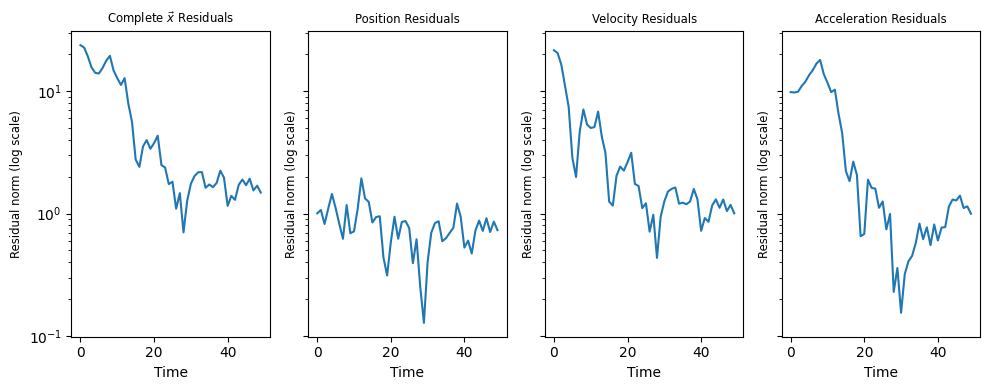

TODO: Why doesn't position residual norm curve look like the others?


In [15]:
# rs = true_xs - xs
# Note this function assumes the given ax is part of a multi subplot figure
def plot_residuals(ax, rs, title=''):
    rs_norms = np.full(N, np.nan)
    for i in range(N):
        rs_norms[i] = np.linalg.norm(rs[i])
    t = np.arange(0,N)
    ax.set_yscale('log')
    ax.plot(t, rs_norms)
    ax.set_title(title, fontsize='small')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residual norm (log scale)', fontsize='small')

# Calculate and plot residuals for multiple (track, estimate) pairs on one figure
def plot_all_residuals_2(tracks, estimates):
    """
    Args:
        tracks: List of true state timeseries
        estimates: List of estimated state timeseries
    """
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10,4))
    
    for track, estimate in zip(tracks, estimates):
        xs_pos, xs_vel, xs_acc = utils.separate_state_series(track)
        true_xs_pos, true_xs_vel, true_xs_acc = utils.separate_state_series(estimate)

        # Complete Residuals
        rs = track - estimate
        plot_residuals(axs[0], rs, title=r'Complete $\vec{x}$ Residuals')

        # Position residuals
        rs = true_xs_pos - xs_pos
        plot_residuals(axs[1], rs, title='Position Residuals')

        # Velocity residuals
        rs = true_xs_vel - xs_vel
        plot_residuals(axs[2], rs, title='Velocity Residuals')

        # Velocity residuals
        rs = true_xs_acc - xs_acc
        plot_residuals(axs[3], rs, title='Acceleration Residuals')
    
    plt.tight_layout()
    plt.show()

plot_all_residuals_2([true_xs], [xs])
print('TODO: Why doesn\'t position residual norm curve look like the others?')

#### Exploring initial state guess perturbations

- Subconcept: Uniform sampling the surface of a $d$-sphere. [Article (see muller method)](https://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/)
    - TODO: Understand and writeup the reasoning for the muller method: That random normal  components form direction vectors that point to uniform positions on a sphere.
    
Take $d$ draws from $\mathcal{N}(0,1)$.

Form a $d$-dimensional vector $\vec{z}$ from those draws.

Since each component is i.i.d. normal, the joint pdf $f(\vec{z})$ is the product of the individual pdfs (__TODO__ confirm this).

In the 2D case:

$f(u,v) = f(\vec{z}) = \left( \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}u^2} \right) \left( \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}v^2} \right)$

$ \frac{1}{2\pi} e^{-\frac{1}{2}(u^2 + v^2)} = \frac{1}{2\pi} e^{-\frac{1}{2}(|\vec{z}|^2)}$

This implies the joint distribution depends only on the _magnitude_ of $\vec{z}$, not the direction. Therefore the distribution is rotation invariant. i.e The distribution is uniform along the sphere of radius $|\vec{z}|$.


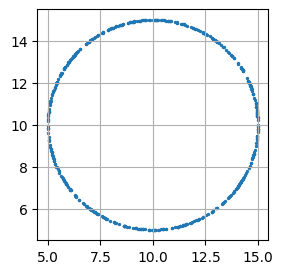

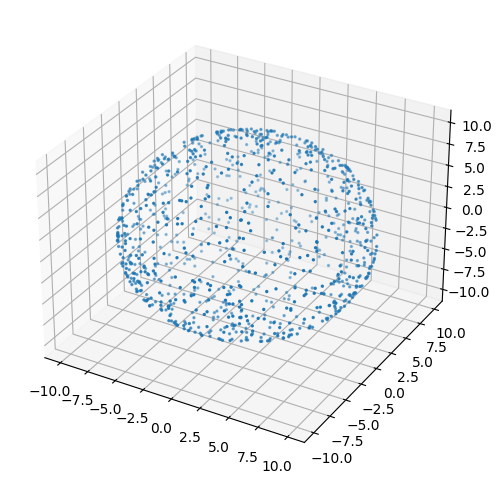

In [16]:
# Testing muller algorithm to generate uniform points on a (d-1)-sphere

# Return a point, selected at uniform random, on a (d-1)-sphere of radius r
def random_point_on_dsphere(r=1, d=2, v0=np.zeros(2)):
    """
    Args
        r: Radius of the d-sphere
        d: Dimension of space. e.g. d=3 creates a sphere (a 2-sphere: 2 degrees of freedom).
        v0: Origin of the d-sphere
    """
    # Pick a d-dimensional direction vector
    # Each component independently drawn from ~N(0,1)
    v = rng.normal(0, 1, d)
    d = np.linalg.norm(v)
    return v0 + (r * v/d)

# d=2: Circle (d-1 = 1 degree of freedom)
figure, axes = plt.subplots(1, figsize=(3,3)) 
axes.set_aspect(1)
r = 5
d = 2
v0 = np.zeros(d) + 10
num_points = 500
points = np.full((num_points,d), np.nan)
for i in range(num_points):
    points[i] = random_point_on_dsphere(r=r, d=d, v0=v0)
axes.scatter(points[:,0], points[:,1], s=2)
plt.grid()
plt.show()

# d=3: Sphere (d-1 = 2 degrees of freedom)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
r = 10
d = 3
v0 = np.zeros(d)
num_points = 1000 # Num points
points = np.full((num_points,d), np.nan)
for i in range(num_points):
    points[i] = random_point_on_dsphere(r=r, d=d, v0=v0)
ax.scatter(points[:,0], points[:,1], points[:,2], s=2)
plt.show()

### Visualizing the $3 \sigma$ membership accuracy score as a function of initial state guess perturbation

In [17]:
# TODO APPROACH 2 - plot a scatterplot of perturbation scale vs accuracy score
d = len(xs[0])
num_incr = 20
samples_per_incr = 100

# For each initial state guess perturbation scale, we'll track the 3-sigma membership
# accuracy score.
results = []

# For p in a set of increasing distances (relative scale to true x0's norm)
for p in np.linspace(0.0, 20.0, num=num_incr):
    # print(f'Random initial state perturbation: {p:.0f} x true initial state norm:')
    
    # Generate random initial state vectors perturbed by p from true initial state x0
    x0_norm = np.linalg.norm(true_xs[0])
    r = x0_norm * p
    init_points = np.full((samples_per_incr, d), np.nan)
    for i in range(samples_per_incr):
        init_points[i] = random_point_on_dsphere(r=r, d=d, v0=true_xs[0]) # TODO reference this perturbation strategy description

    # Run Kalman filter and check accuracy for each initial (position) state guess
    for v_0 in init_points:
        P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
        xs, Ps = kalman_6d(zs, R, Q, v_0, P_0)
        xs_pos, _, _ = utils.separate_state_series(xs)
        true_xs_pos, _, _ = utils.separate_state_series(true_xs)
        Ps_pos, _, _ = utils.separate_covar_series(Ps)
        ratio = ratio_within_confidence_ellipse(true_xs_pos, xs_pos, Ps_pos)
        results.append((p, ratio))
        # TODO Calculate accuracy ratios for velocity and acceleration also?
        # TODO Calculate NEES score? abcde
        
results = np.array(results)
assert len(results) == num_incr * samples_per_incr

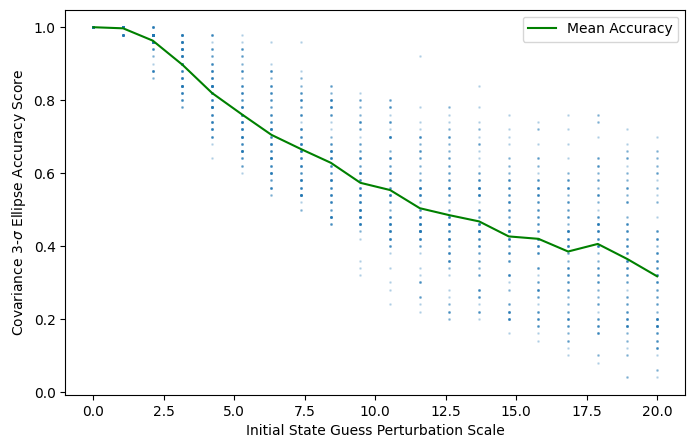

In [18]:
# Calculate mean accuracy score for each perturbation scale value
# Had to do so manually because I couldn't get np's 2d Histogram working
x_vals = np.unique(results[:,0])
avg_y_vals = np.zeros(len(x_vals))
dxy = dict(zip(x_vals, [[] for i in range(len(x_vals))]))
for r in results:
    dxy[r[0]].append(r[1])
for i in range(len(x_vals)):
    x = x_vals[i]
    y_vals = dxy[x]
    avg_y_vals[i] = np.mean(y_vals)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(results[:,0], results[:,1], s=1, alpha=0.2)
ax.plot(x_vals, avg_y_vals, color='green', label='Mean Accuracy')
ax.set_xlabel("Initial State Guess Perturbation Scale")
ax.set_ylabel(r"Covariance 3-$\sigma$ Ellipse Accuracy Score")
ax.set_title("")
ax.legend()
plt.show()
glue('3sm_v_perturbation', fig, display=False)

Notes on above:

- When graphing in log scale, they all appear to have a middle period of linear-looking decline (regardless of initial position). The initial period is more volatile, and the final period is a leveling of (convergence). None converge at zero, which makes sense.

### Exploring parameter space for the multivariable kalman filter example

In our initial exploration, we assumed we could configure the filter's $Q$ and $R$ values perfectly (i.e. to the noise values that were used to generate the synthetic data). But what about the more realistic scenario where we don't know the true $Q$ and $R$ values? 

Let $Q*$ and $R*$ be the true process and measurement noise covariance matrices, respectively.

Below we explore tuning the filter's assumed $Q$ and $R$ covariance matrices to percentages in the range of $[0, 1000]$%.

Q is process noise. R is measurement noise.
Q * 5.0.  R * 0.1.


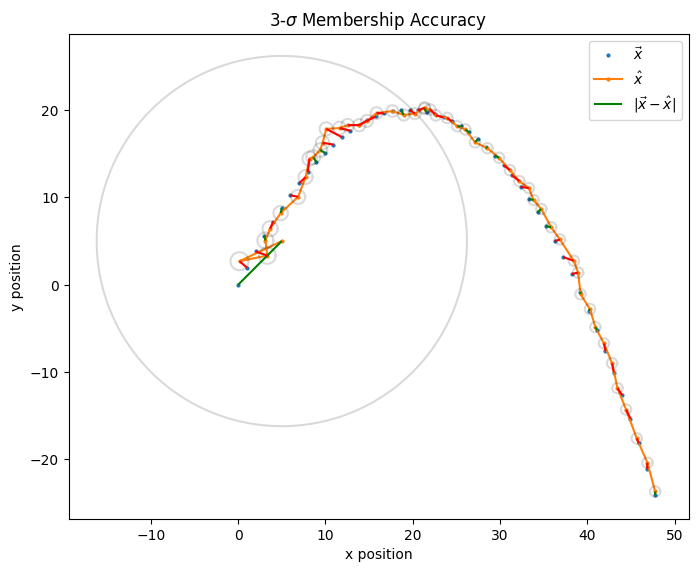

Percent of estimate covar ellipse containing true state: 40.00%


In [21]:
# TODO the following code block is now about generating an examle visual of the 3-sigma membership
# accuracy score logic. Move it into the section about the score implementation.

# Iterate through the (Q,R) parameter space 
# In terms of percentages of the true param values
num_iters = 1

print('Q is process noise. R is measurement noise.')

Q_scale = 5.0
R_scale = 0.1
Q = Q_true * Q_scale
R = R_true * R_scale

print(f'Q * {Q_scale:.01f}.  R * {R_scale:.01f}.')

# Run Kalman filter for (Q,R) combo
P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
v_0 = np.array([5., 0, 0, 5, 0, 0]) # Start with an ok initial state
xs, Ps = kalman_6d(zs, R, Q, v_0, P_0)

xs_pos, _, _ = utils.separate_state_series(xs)
true_xs_pos, _, _ = utils.separate_state_series(true_xs)
Ps_pos, _, _ = utils.separate_covar_series(Ps)
fig, ax = plt.subplots(1, figsize=(8,8))
plot_3sig_membership_acccuracy(true_xs_pos, xs_pos, Ps_pos, ax=ax, n_std=3.0, 
                     xlabel='x position', ylabel='y position')
glue('3sig_membership_viz', fig, display=False)

ratio = ratio_within_confidence_ellipse(true_xs_pos, xs_pos, Ps_pos)
glue('3sm_ratio', ratio)

__TODO__ Deprecate the above less convincing exploration of param space accuracy via residuals for the below approach?

In [ ]:
# Attempt 2 at exploring param space

# Run the kalman filter and compute the position estimate covar accuracy score 
# for the given Q_scale and R_scale factor
def covar_accuracy_score(Q_scale, R_scale):
    #print(f'Q_scale:{Q_scale:.04f}. R_scale:{R_scale:.04f}.')
    Q = Q_true * Q_scale
    R = R_true * R_scale

    # Run Kalman filter for (Q,R) combo
    P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
    v_0 = np.array([5., 0, 0, 5, 0, 0]) # Start with an ok initial state
    xs, Ps = kalman_6d(zs, R, Q, v_0, P_0)

    xs_pos, _, _ = utils.separate_state_series(xs)
    true_xs_pos, _, _ = utils.separate_state_series(true_xs)
    Ps_pos, _, _ = utils.separate_covar_series(Ps)
    assert len(xs_pos[0]) == 2

    # TODO call function defined for this earalier on
    accurate_ellipses = within_confidence_ellipse(true_xs_pos, xs_pos, Ps_pos)
    return np.sum(accurate_ellipses) / len(accurate_ellipses)

# Iterate through the (Q,R) parameter space 
# In terms of percentages of the true param values
num_iters = 20

# The Q and R matrices are simple, they can be represented by their top left corner
# i.e. the variance of the x position
Q_scales = np.linspace(10**-6, 5.0, num=num_iters)
R_scales = np.linspace(10**-1, 1.0, num=num_iters)

# Meshgrid it and calculate surface of accuracy scores
QQ_scales, RR_scales = np.meshgrid(Q_scales, R_scales)
est_ellipse_accuracy_scores = np.vectorize(covar_accuracy_score)(QQ_scales, RR_scales)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(QQ_scales, RR_scales, est_ellipse_accuracy_scores, cmap='viridis')
ax.set_xlabel('Q Scale')
ax.set_ylabel('R Scale')
ax.set_zlabel('Accuracy')
plt.show()


fig, ax = plt.subplots(1, figsize=(3,3)) 
#ax = fig.add_subplot(111, projection='3d')
ax.contour(QQ_scales, RR_scales, est_ellipse_accuracy_scores)
ax.set_xlabel('Q Scale')
ax.set_ylabel('R Scale')
plt.show()
        
# TODO do same contour plot for average NEES score

__TODO__ Things to explore and illustrate:
- Measuring accuracy of the filter.
  - Use the NEES to confirm the _consistency_ of the kalman estimate. Instructions [here](https://kalman-filter.com/normalized-estimation-error-squared/).
- Hidden Variables: i.e. velocity and acceleration in the above model where I only have position sensor.
- __Exploring the relationship between position and velocity covariance (as in Labbe chapter 6 section on "Prediction Equations")__
- Forecasting: Use the trained kalman filter to predict into the future
- Find a better data set on which to demonstrate the filter's usefulness
- Tuning the filter: 
  - What if we're wrong about setting our process and noise uncertainties?
  - Sensitivity to initial guess.
  - For each question, do many filter runs across all parameter states and evaluate the performance:
      - Accuracy rating
      - Amount of steps before 'convergence'
      
      
__TODO__ Things to check or fix
- Confirm your covariance ellipse scale factor is correct. [Looks different than some descriptions - not converting to chi-square s scale factor](https://www.xarg.org/2018/04/how-to-plot-a-covariance-error-ellipse/). OR actually it may be the Mahalanobis distance described [here](https://cookierobotics.com/007/). Check if its right or not.